# Motionsense
Download data from Kaggle: [MotionSense Dataset: Sensor Based Human Activity and Attribute Recognition][motion_website].

Download the datasets and run this script.

[motion_website]: https://www.kaggle.com/malekzadeh/motionsense-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_subjects = pd.read_csv("./data/data_subjects_info.csv", index_col = 0)
data_subjects.head()

,weight,height,age,gender
code,,,,
1,102,188,46,1
2,72,180,28,1
3,48,161,28,0
4,90,176,31,1
5,48,164,23,0


Let's import and look a single datastream first.

In [3]:
data_stream_1subject = pd.read_csv("./data/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_1.csv", index_col = 0)
data_stream_1subject.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-1.711140,-1.429168,-2.591433,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,-1.787917,-1.414171,-2.630956,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,-1.897323,-1.399331,-2.706668,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,-2.018375,-1.383279,-2.813421,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,-2.124395,-1.364054,-2.913092,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201


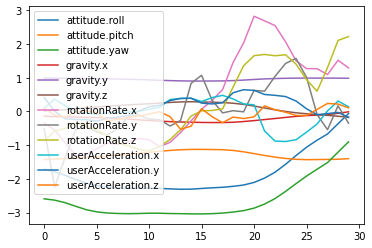

In [4]:
data_stream_1subject.iloc[0:30].plot()
plt.show()

Let's isolate the acceleration data and look at that first. It is possible that's all we need.

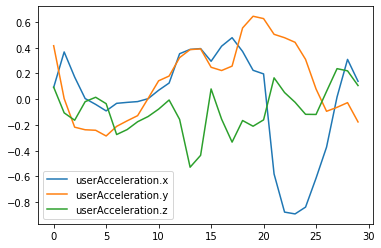

In [5]:
acc_cols = ["userAcceleration.x", "userAcceleration.y", "userAcceleration.z"]
data_stream_1subject[acc_cols].iloc[0:30].plot()
plt.show()

This data would depend on the accelerometers orientation and could possible confuse the learning process (Although, we don't really know this, it could instead be a source for additional features with additional information). Therefore, we should also look at the cartesian length of the acceleration. This is also called the norm_2: 

$||a||_2 = \sqrt{a_x^2 + a_y^2 + a_z^2}$

In [6]:
data_stream_1subject["norm2Acc"] = np.sqrt((data_stream_1subject[acc_cols]**2).sum(axis = 1))

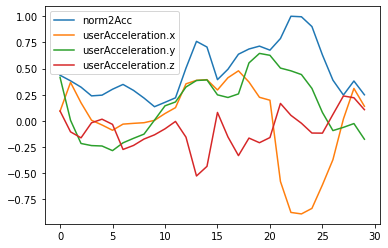

In [7]:
data_stream_1subject[["norm2Acc"] + acc_cols].iloc[0:30].plot()
plt.show()

The cartesian length of the acceleration has a few desirable properties. It is always positive and represents the magnitude of the acceleration where direction is discarded. 

Another possibly useful value is the norm 1, the sum of the abolute values of the components:

$||\mathbf{a}|| = \Sigma_i|a_i|$

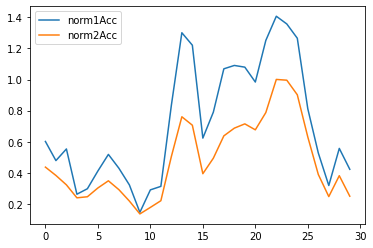

In [8]:
data_stream_1subject["norm1Acc"] = np.abs(data_stream_1subject[acc_cols]).sum(axis = 1)
data_stream_1subject[["norm1Acc", "norm2Acc"]].iloc[0:30].plot()
plt.show()

The norm1 behaves somewhat differently than norm2. We will include both in our pipeline.

Lets perform the same analysis on the rotation data.

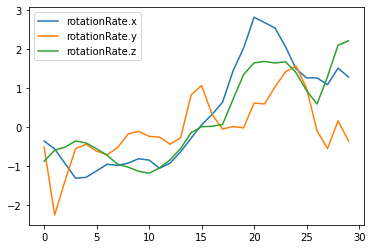

In [9]:
rot_cols = ["rotationRate.x", "rotationRate.y", "rotationRate.z"]
data_stream_1subject[rot_cols].iloc[0:30].plot()
plt.show()

In [10]:
data_stream_1subject["norm1Rot"] = np.sqrt((data_stream_1subject[rot_cols]**2).sum(axis=1))
data_stream_1subject["norm2Rot"] = np.abs(data_stream_1subject[rot_cols]).sum(axis=1)

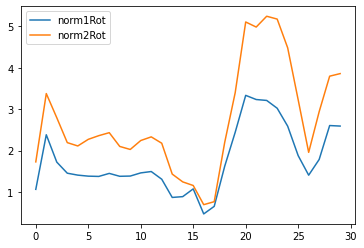

In [11]:
data_stream_1subject[["norm1Rot", "norm2Rot"]].iloc[0:30].plot()
plt.show()

It is possible the data from rotation rate can be used to determine that the subject is doing something other than walking. But that remains to be seen. Lets also take a closer look at the attitude columns.

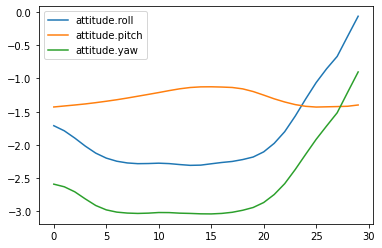

In [12]:
attitude_cols = ["attitude.roll", "attitude.pitch", "attitude.yaw"]
data_stream_1subject[attitude_cols].iloc[0:30].plot()
plt.show()

These features should store the same kinds of information as the rotation rate, but in a different manner (the attitude would be the accumulated rotation rate). Still, that can come in handy as it gives the algorithm a different perspective to look at.

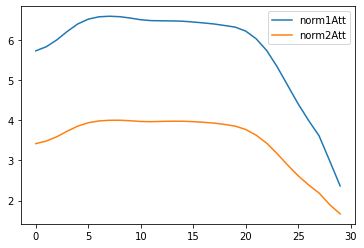

In [13]:
data_stream_1subject["norm1Att"] = np.abs(data_stream_1subject[attitude_cols]).sum(axis=1)
data_stream_1subject["norm2Att"] = np.sqrt((data_stream_1subject[attitude_cols]**2).sum(axis=1))
data_stream_1subject[["norm1Att", "norm2Att"]].iloc[0:30].plot()
plt.show()

Lets take a look at the gravity columns.

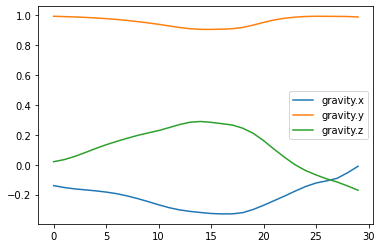

In [14]:
gravity_cols = ["gravity.x", "gravity.y", "gravity.z"]
data_stream_1subject[gravity_cols].iloc[0:30].plot()
plt.show()

In [15]:
np.sqrt((data_stream_1subject[gravity_cols]**2).sum(axis=1)).mean()

0.9999999990000324

The information stored in the gravity columns tell us that gravity has already been accounted for. The original acceleration data $A$ was $A_i = a_i + g_i$, where $a$ is acceleration, $g$ is acceleration due to gravity and $i$ is the direction $x, y, z$. This means we don't have to and we will ignore effects due to gravity and the gravity columns from here on.

Lets compile everything together with labelling datasets depicting walking as 1 and 0 for everything else in a new target column.

In [16]:
def createFeatures(dataframe):
    new_dataframe = pd.DataFrame()
    new_dataframe["norm1Acc"] = np.abs(dataframe[acc_cols]).sum(axis = 1)
    new_dataframe["norm2Acc"] = np.sqrt((dataframe[acc_cols]**2).sum(axis = 1))
    new_dataframe["norm1Rot"] = np.abs(dataframe[rot_cols]).sum(axis = 1)
    new_dataframe["norm2Rot"] = np.sqrt((dataframe[rot_cols]**2).sum(axis = 1))
    new_dataframe["norm1Att"] = np.abs(dataframe[attitude_cols]).sum(axis = 1)
    new_dataframe["norm2Att"] = np.sqrt((dataframe[attitude_cols]**2).sum(axis = 1))
    return new_dataframe

In [17]:
data_path = "./data/A_DeviceMotion_data/A_DeviceMotion_data/"
folders = os.listdir(data_path)

filenames = np.array([[data_path + subfolder + "/" + name for name in os.listdir(data_path + subfolder)] for subfolder in folders]).reshape(-1)
dataframes = [createFeatures(pd.read_csv(filename, index_col = 0)) for filename in filenames]

In [18]:
print(dataframes[0].head())

   norm1Acc  norm2Acc  norm1Rot  norm2Rot  norm1Att  norm2Att
0  0.059144  0.039817  0.119989  0.070999  4.620004  2.683262
1  0.011295  0.009494  0.242220  0.143030  4.540719  2.637953
2  0.066471  0.038906  0.204076  0.119781  4.458752  2.591593
3  0.097838  0.059127  0.224392  0.137688  4.389319  2.552763
4  0.084230  0.056125  0.230971  0.150669  4.307808  2.507671


Now, let's split each dataframe into smaller fragments. When doing this, lets do sover a moving window and do so lazily. 

In [19]:
batch_len = 100

def batch_buffer(dataframe, batch_len = batch_len):
    return [dataframe.iloc[i * batch_len: (i + 1) * batch_len] for i in range(int((len(dataframe) - batch_len) / batch_len))]

In [20]:
target_names = [name.split("/")[-2][:3] for name in filenames]
X = np.array([])
y = []
for dataframe, target in zip(dataframes, target_names):
    acc = np.array(batch_buffer(dataframe["norm2Acc"]))
    rot = np.array(batch_buffer(dataframe["norm2Rot"]))
    sample = np.concatenate([acc, rot], axis = 1)
    y = y + [target] * acc.shape[0]
    if not len(X):
        X = sample
    else:
        X = np.concatenate([X, sample], axis = 0)
y = np.array(y)
print(X.shape, y.shape)

(13592, 200) (13592,)


The map object buffered_df will produce the desired dataframes while we iterate over the object. Now lets reserve the last few batches as test sets and the first as training sets.

In [21]:
y = np.array(y == 'wlk').astype(int)

In [22]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
svc = svm.SVC()

params = {'kernel': ['linear', 'rbf'], 
          'C': logspace(-1, 1, 3),

         }

clf = GridSearchCV(svc, params, n_jobs = 4)

In [ ]:
clf.fit(Xtrain, ytrain)
clf.cv_results_